In [70]:
import pandas as pd
import numpy as np
import glob


SRC_PATH = "./archive/*.csv"
FIELD = 'Pload_actual'

In [71]:
src_files = glob.glob(SRC_PATH)
src_files.sort()
print(src_files)

dst_df = pd.DataFrame()
for f in src_files:
    print(f) 
    df = pd.read_csv(f)        
    df['Time_actual'] = pd.to_datetime(df['Time_actual'], format='%Y-%m-%d %H:%M:%S')
    df['Time'] = df['Time_actual'].dt.strftime("%H:%M:%S")
    df['Time'] = pd.to_datetime(df['Time'], format='%H:%M:%S')
    print(df.head())
    print(df.dtypes)
    # df.Time_actual = pd.to_datetime(df.Time_actual).dt.strftime('%H:%M')
    df = df.groupby(pd.Grouper(key='Time', freq='30min')).mean().dropna()          
    dst_df = dst_df._append(df[FIELD].T)

dst_df.reset_index(drop=True, inplace=True)
dst_df.fillna(value=np.nan, inplace=True)
dst_df.fillna(0, inplace=True)
dst_df.to_csv(f'./{FIELD}.csv', index=False)


['./archive/2021-11-14_data.csv', './archive/2021-12-13_data.csv', './archive/2022-01-03_data.csv', './archive/2022-02-01_data.csv', './archive/2022-03-01_data.csv', './archive/2022-04-01_data.csv', './archive/2022-05-02_data.csv', './archive/2022-06-01_data.csv', './archive/2022-07-01_data.csv', './archive/2022-08-01_data.csv', './archive/2022-09-01_data.csv', './archive/2022-10-03_data.csv', './archive/2022-11-01_data.csv', './archive/2022-12-01_data.csv', './archive/2023-01-01_data.csv', './archive/2023-02-03_data.csv', './archive/2023-03-01_data.csv', './archive/2023-04-04_data.csv', './archive/2023-05-02_data.csv', './archive/2023-06-01_data.csv', './archive/2023-07-01_data.csv', './archive/2023-08-01_data.csv', './archive/2023-09-01_data.csv']
./archive/2021-11-14_data.csv
          Time_actual  Ppv_actual  Qpv_actual  Pload_actual  Qload_actual  \
0 2021-11-14 00:00:26           0           0     64.811157  -1045.206543   
1 2021-11-14 00:00:56           0           0     65.504

In [ ]:
import matplotlib.pyplot as plt
select=[1, 4, 7, 10, 13, 16, 19, 22]

df = pd.read_csv(f'{FIELD}.csv').T
df[[x+1 for x in select]].plot()
plt.legend(select)

SyntaxError: invalid syntax (2637371376.py, line 5)

In [73]:
from sdv.metadata import SingleTableMetadata
from sdv.single_table import GaussianCopulaSynthesizer
from sdv.single_table import CTGANSynthesizer

def train_synthetic_model(name, df):
    metadata = SingleTableMetadata()
    metadata.detect_from_dataframe(df)
    metadata.to_dict()

    synthesizer = GaussianCopulaSynthesizer(metadata)
    synthesizer.fit(df)

    synthesizer = CTGANSynthesizer(
        metadata, # required
        enforce_rounding=False,
        epochs=100,
        verbose=True
    )

    synthesizer.get_parameters()
    metadata = synthesizer.get_metadata()
    synthesizer.fit(df)
    synthesizer.save(
        filepath=f'{name}.pkl'
    )

def gen_synthetic_data(name):
    synthesizer = CTGANSynthesizer.load(
        filepath=f'{name}.pkl'
    )

    synthetic_data = synthesizer.sample(num_rows=20)
    synthetic_data.to_csv(f'./{name}_synthetic_data.csv', encoding='utf8', index=False)
    return synthetic_data
    

In [74]:
legends=['1', '4', '7', '10']
df = pd.read_csv(f'{FIELD}.csv').T
# df[[2, 5, 8, 11]].plot()

syn_data = pd.DataFrame()
for i, l in enumerate(legends):
    train_synthetic_model(l, df[[i*3+1, i*3+2, i*3+3]].T)
    syn = gen_synthetic_data(l)
    syn_data = syn_data._append(syn)
    
syn_data.to_csv(f'./season_synthetic_data.csv', encoding='utf8', index=False)

    

/Users/jwheo/Projects/etc_project/.venv/lib/python3.10/site-packages/sdv/single_table/base.py:120: FutureWarning: The 'SingleTableMetadata' is deprecated. Please use the new 'Metadata' class for synthesizers.
  warnings.warn(DEPRECATION_MSG, FutureWarning)
/Users/jwheo/Projects/etc_project/.venv/lib/python3.10/site-packages/sdv/single_table/base.py:105: UserWarning: We strongly recommend saving the metadata using 'save_to_json' for replicability in future SDV versions.
  warnings.warn(
/Users/jwheo/Projects/etc_project/.venv/lib/python3.10/site-packages/sdv/single_table/base.py:120: FutureWarning: The 'SingleTableMetadata' is deprecated. Please use the new 'Metadata' class for synthesizers.
  warnings.warn(DEPRECATION_MSG, FutureWarning)
Gen. (1.44) | Discrim. (-0.02): 100%|██████████| 100/100 [00:15<00:00,  6.42it/s]
/Users/jwheo/Projects/etc_project/.venv/lib/python3.10/site-packages/sdv/single_table/base.py:120: FutureWarning: The 'SingleTableMetadata' is deprecated. Please use the 

In [75]:
ld = pd.read_csv(f'season_synthetic_data.csv').T
# ld.plot(legend=False)
data = list()

for l in ld:
    ld_list = ld[l].to_list()
    data.append(ld_list)

ld    

,0,1,2,3,4,5,6,7,8,9,...,70,71,72,73,74,75,76,77,78,79
1900-01-01 00:00:00,321.583360,242.235042,213.928617,262.392297,213.928617,213.928617,289.320323,213.928617,213.928617,213.928617,...,530.320804,489.970085,530.320804,530.320804,425.822053,236.348160,530.320804,530.320804,530.320804,530.320804
1900-01-01 00:30:00,234.739458,201.101435,225.936631,201.101435,201.101435,232.566982,201.101435,202.909774,201.101435,201.101435,...,440.023079,174.494199,324.792928,388.801833,204.645545,440.023079,440.023079,440.023079,159.334756,440.023079
1900-01-01 01:00:00,196.674519,196.674519,200.044707,231.465923,219.374968,239.935248,215.701236,223.556550,244.705267,220.512633,...,410.597603,274.254846,383.094964,410.597603,410.597603,410.597603,410.597603,410.597603,221.516709,410.597603
1900-01-01 01:30:00,214.488399,218.548957,218.232818,217.643794,207.156672,218.548957,212.183032,218.548957,208.414910,211.113550,...,357.626709,357.626709,357.626709,357.626709,357.626709,357.626709,357.626709,357.626709,357.626709,279.173457
1900-01-01 02:00:00,287.832078,239.279671,287.832078,237.950912,287.832078,280.788763,271.166193,287.832078,287.832078,194.080219,...,334.633626,334.633626,334.633626,334.633626,334.633626,274.766868,334.633626,334.633626,315.815873,302.170959
1900-01-01 02:30:00,273.914204,200.212165,269.460955,211.638894,276.508449,262.486242,246.619802,242.015220,234.443653,214.037694,...,268.132676,302.936555,268.132676,268.132676,268.132676,268.132676,268.132676,268.132676,337.450501,268.132676
1900-01-01 03:00:00,267.137021,277.763622,183.948182,277.763622,277.763622,277.763622,227.283392,277.763622,215.123859,189.509842,...,402.778587,271.118155,530.502571,271.118155,271.118155,271.118155,271.118155,271.118155,271.118155,271.118155
1900-01-01 03:30:00,215.802789,165.680556,165.680556,183.148998,237.805706,271.443507,271.443507,271.443507,212.320457,165.680556,...,299.190256,264.398385,344.592917,335.876985,264.398385,264.398385,264.398385,401.748422,315.363117,264.398385
1900-01-01 04:00:00,236.160517,236.160517,236.160517,236.160517,224.002581,213.405845,236.160517,236.160517,186.823829,236.160517,...,267.742725,267.742725,267.742725,268.245228,267.742725,380.920225,267.742725,368.455927,267.742725,267.742725
1900-01-01 04:30:00,239.129224,226.541299,182.682219,255.116126,218.317046,241.210664,185.935847,255.116126,255.116126,208.302653,...,199.938523,199.938523,199.938523,199.938523,199.938523,392.879749,293.288422,199.938523,267.764853,199.938523


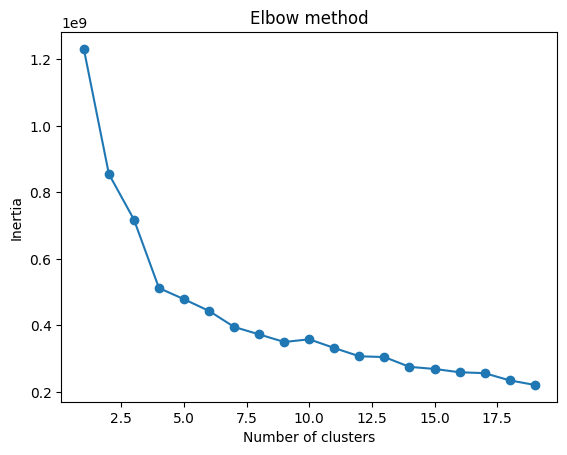

In [76]:
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

num_cluster = 20
inertias = []
for i in range(1,num_cluster):
    kmeans = KMeans(n_clusters=i)
    kmeans.fit(data)
    inertias.append(kmeans.inertia_)

plt.plot(range(1,num_cluster), inertias, marker='o')
plt.title('Elbow method')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
plt.show()


In [77]:
NC = 4
kmeans = KMeans(n_clusters=NC)
kmeans.fit(data)

print(kmeans.labels_)


[3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1]


RangeIndex(start=0, stop=80, step=1)


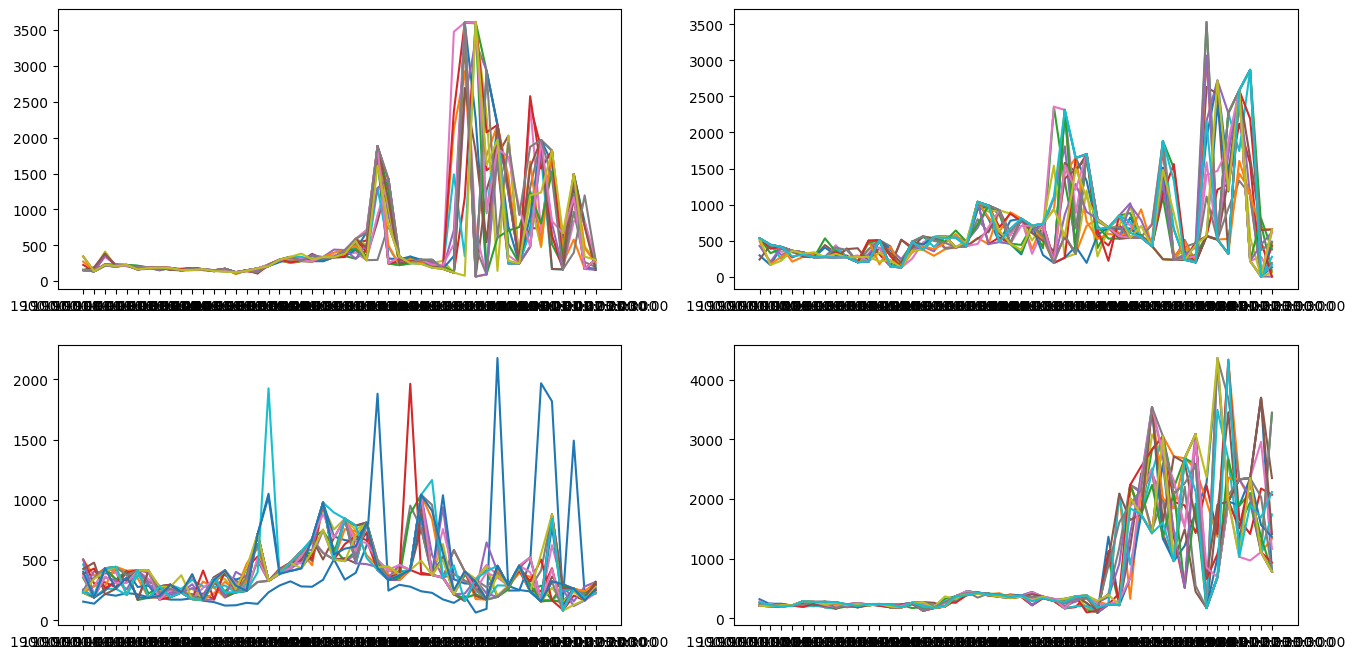

In [78]:
plt.figure(figsize=(16,8))
print(ld.columns)
for i in range(len(ld.columns)):
    plt.subplot(2, 2, kmeans.labels_[i]+1)
    plt.plot(ld[i])